In [69]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy.stats import norm

In [70]:
def calculate_delta(S, K, T, t, r, sigma, eps):
    d1 = (np.log(S/K) + (r + sigma ** 2 / 2) * (T - t)) / (sigma * np.sqrt(T - t) + eps)
    return norm.cdf(d1)

In [71]:
# Black-Scholes Call Price (in fact did not need whole equation)
def black_scholes_call(S: float, K: float, T: float, t: float, r: float, sigma: float, eps: float) -> float:
    """
    Calculate Black-Scholes call option price.
    
    Args:
        S: Current stock price
        K: Strike price
        T: Time to maturity
        t: Current time
        r: Risk-free rate
        sigma: Volatility
        eps: Small number for numerical stability
    
    Returns:
        float: Call option price
    """
    d1 = (np.log(S/K) + (r + sigma ** 2 / 2) * (T - t)) / (sigma * np.sqrt(T - t) + eps)
    d2 = d1 - sigma * np.sqrt(T-t)
    return S * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)

In [72]:
def calc_delta_recursive(S, K, T, t, r, C_0, eps=np.finfo(float).eps, tol=0.1, max_tol=2.0):
    """
    Recursively calculate delta with increasing tolerance until solution is found
    or max_tolerance is reached
    """
    if tol > max_tol:
        # print(f"Warning: No solution found within tolerance {max_tol}")
        print(f"Delta = 1, sigma = 0, call from BS if sigma = 0: {black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=0, eps=eps)} Call price from data = {C_0}")
        return 1, 0  # Return None and skip delta calculation

    for sigma in np.arange(0, 5, 0.001):
        c = black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
        if abs(c - C_0) <= tol:
            delta = calculate_delta(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
            return delta, sigma

    # print(f'Increasing tolerance from {tol} to {tol + 0.2}')
    return calc_delta_recursive(S, K, T, t, r, C_0, eps, tol + 0.2, max_tol)

In [73]:
def calc_delta(S, K, T, t, r, C_0, eps=np.finfo(float).eps, tol=0.1):

    for sigma in np.arange(0, 5, 0.001):
        c = black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
        if abs(c-C_0) <= tol:
            delta = calculate_delta(S=S, K=K, T=T, t=t, r=r, sigma=sigma, eps=eps)
            # print(f"Delta = {delta}, sigma = {sigma}, Price: {S}, S-C={S-C_0} \ncall price from BS = {round(c, 5)}, Call price from data = {C_0}")
            return delta
    print(f"Delta = 1, sigma = 0, call from BS if sigma = 0: {black_scholes_call(S=S, K=K, T=T, t=t, r=r, sigma=0, eps=eps)} Call price from data = {C_0}")
    return 1

In [74]:
def hedging_looped1(interval, strike, analysis_df, delta, C_0, S_0, maturity_date, T, r, replicating_portfolio, option_portfolio):
    """
    Delta hedging implementation
    
    Args:
        interval: Rehedging interval
        strike: Strike price identifier (e.g., 'C180')
        df: DataFrame containing option prices
        delta: Initial delta
        C_0: Initial option price
        S_0: Initial stock price
        maturity_date: Option maturity date
        T: Time to maturity
        r: Risk-free rate
        RE_0: Initial replicating portfolio value
        OP_0: Initial option portfolio value
    """
    errors = []
    current_delta = delta

    for i in range(0, len(analysis_df), interval):
        current_row = analysis_df.iloc[i]
        S_t = current_row['Underlying']
        C_t = current_row[strike]
        t = (maturity_date - current_row['Date'].date()).days / 365

        current_delta, _ = calc_delta_recursive(S=S_t, K=float(strike.replace('C', '')), T=T, t=t, r=r, C_0=C_t)

        replicating_portfolio = current_delta * S_t
        option_portfolio = C_t

        error = option_portfolio - replicating_portfolio
        errors.append(error**2)

    mse = np.mean(errors)
    return mse

In [75]:
def hedging_looped2(interval, strike, df, delta, C_0, S_0, maturity_date, T, r):
    """
    Delta hedging implementation

    Args:
        interval: Rehedging interval
        strike: Strike price identifier (e.g., 'C180')
        df: DataFrame containing option prices
        delta: Initial delta
        C_0: Initial option price
        S_0: Initial stock price
        maturity_date: Option maturity date
        T: Time to maturity
        r: Risk-free rate
    """
    A_boss = 0
    interval_count = 1
    c_0 = C_0
    c_1 = 0
    s_0 = S_0
    s_1 = 0
    t = 0
    n = 0

    K = float(strike.split('C')[1])

    for _, row in df.iterrows():
        c_1 = float(row[strike])
        s_1 = float(row['Underlying'])

        t = (45 - (maturity_date - row['Date'].date()).days) / 365

        if row.name == 0:
            continue

        OP = c_1 - c_0
        RE = -delta * (s_1 - s_0)
        A = OP + RE
        A_boss += A ** 2
        n += 1

        if interval_count % interval == 0:
            
            delta = calc_delta(s_1, K, T, t, r, c_1)
            

        c_0 = c_1
        s_0 = s_1
        interval_count += 1

    mse = A_boss / (n - 1)
    return mse

In [76]:
def run_hedging_analysis(filename, interval=2, risk_free_rate=0.05):
    df = pd.read_feather(filename)
    df['Date'] = pd.to_datetime(df['Date'])

    df['Underlying'] = pd.to_numeric(df['Underlying'], errors='coerce')
    for col in [col for col in df.columns if col.startswith('C')]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    date_str = filename.split('apple')[1].split('.')[0]
    maturity_date = dt.datetime.strptime(date_str, '%d%m%Y').date()


    t = 0
    r = risk_free_rate / 100
    eps = np.finfo(float).eps

    # Define time window
    T = 45 / 365  # Original option: 45 days

    start_date = maturity_date - dt.timedelta(days=45)
    analysis_df = df[df['Date'].dt.date >= start_date]
    analysis_df = analysis_df[analysis_df['Date'].dt.date <= maturity_date]
    
    if not analysis_df.empty:
        hedging_start_value = analysis_df.loc[analysis_df['Date'].dt.date == start_date, 'Underlying']
        if not hedging_start_value.empty:
            print(f"Hedging Start Date: {start_date}, Underlying Value: {hedging_start_value.values[0]}")
        else:
            print(f"No underlying value found for the hedging start date: {start_date}")
    else:
        print(f"No data available for the analysis window {start_date} to {maturity_date}")

    strikes = [col.replace('C', '') for col in df.columns if col.startswith('C') and not df[col].isna().any()]
    print()
    print(strikes)

    results = []
    for k in strikes:
        print(f"-------------- Strike: {k} ----------------")
        strike = f'C{k}'


        C_0 = float(analysis_df[strike].iloc[0])
        S_0 = float(analysis_df['Underlying'].iloc[0])

        delta, _ = calc_delta_recursive(S=S_0, K=float(k), T=T, t=t, r=r, C_0=C_0)
        # delta = calc_delta(S_0, float(k), T, t, r, C_0)

        # delta_error = hedging_looped1(interval, strike, analysis_df, delta, C_0, S_0, 
        #                              maturity_date, T, r, -delta * S_0, C_0)
        
        delta_error = hedging_looped2(interval, strike, analysis_df, delta, C_0, S_0, 
                                     maturity_date, T, r)

        # Save results
        option_period = (analysis_df['Date'] - analysis_df['Date'].iloc[0]).dt.days.tolist()
        deltas = [calc_delta_recursive(S=row['Underlying'], K=float(k), T=T, 
                                       t=(maturity_date - row['Date'].date()).days / 365, 
                                       r=r, C_0=row[strike])[0] for _, row in analysis_df.iterrows()]

        results.append({
            "Strike": k,
            "Delta_MSE": delta_error,
            "Option_Period": option_period,
            "Deltas": deltas,
            "Underlying": S_0 
        })

        print(f"Strike {k}: Delta MSE = {delta_error:.6f}, {start_date} -- {maturity_date}")

    return pd.DataFrame(results)

In [77]:
dates = ['19012024', '16022024', '15032024','19042024','17052024', '21062024', '19072024', '16082024', '20092024','25102024']  # Add all maturity dates
for date in dates:
    filename = f'data/apple{date}.feather'
    df = pd.read_feather(filename)
    maturity_date = dt.datetime.strptime(date, '%d%m%Y').date()
    hedging_start_date = maturity_date - dt.timedelta(days=45)
    hedging_start_value = df.loc[df['Date'].dt.date == hedging_start_date, 'Underlying']
    print()
    print(f"Hedging Start: {hedging_start_date} | Maturity: {maturity_date}")
    print(f"Underlying Value: {hedging_start_value.values[0]}")
    


Hedging Start: 2023-12-05 | Maturity: 2024-01-19
Underlying Value: 193.42

Hedging Start: 2024-01-02 | Maturity: 2024-02-16
Underlying Value: 185.64

Hedging Start: 2024-01-30 | Maturity: 2024-03-15
Underlying Value: 188.04

Hedging Start: 2024-03-05 | Maturity: 2024-04-19
Underlying Value: 170.12

Hedging Start: 2024-04-02 | Maturity: 2024-05-17
Underlying Value: 168.84

Hedging Start: 2024-05-07 | Maturity: 2024-06-21
Underlying Value: 182.4

Hedging Start: 2024-06-04 | Maturity: 2024-07-19
Underlying Value: 194.35

Hedging Start: 2024-07-02 | Maturity: 2024-08-16
Underlying Value: 220.27

Hedging Start: 2024-08-06 | Maturity: 2024-09-20
Underlying Value: 207.23

Hedging Start: 2024-09-10 | Maturity: 2024-10-25
Underlying Value: 220.11


In [78]:
dates = ['19012024', '16022024', '15032024', '19042024','17052024','21062024','19072024','16082024','20092024','25102024']  # Add all maturity dates
all_results = []
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve

risk_free_rates = {  # Risk free rates for each maturity, risk free rate is chosen 1 month Daily Treasury Par Yield Curve Rates for the hedging start date
    '19012024': 5.54,
    '16022024': 5.55,
    '15032024': 5.53,
    '19042024': 5.50,
    '17052024': 5.49,
    '21062024': 5.51,
    '19072024': 5.48,
    '16082024': 5.48,
    '20092024': 5.50,
    '25102024': 5.18
}

for date in dates:
    filename = f'data/apple{date}.feather'
    r = risk_free_rates.get(date, 0.05)
    results = run_hedging_analysis(filename, risk_free_rate=r)
    results["Maturity"] = date
    all_results.append(results)

final_results = pd.concat(all_results)

final_results.to_csv("hedging_results.csv", index=False)

Hedging Start Date: 2023-12-05, Underlying Value: 193.42

['200', '210', '220']
-------------- Strike: 200 ----------------
Delta = 1, sigma = 0, call from BS if sigma = 0: 0.0 Call price from data = 2.29
Strike 200: Delta MSE = 0.023695, 2023-12-05 -- 2024-01-19
-------------- Strike: 210 ----------------
Strike 210: Delta MSE = 0.001475, 2023-12-05 -- 2024-01-19
-------------- Strike: 220 ----------------
Strike 220: Delta MSE = 0.000201, 2023-12-05 -- 2024-01-19
Hedging Start Date: 2024-01-02, Underlying Value: 185.64

['200', '210']
-------------- Strike: 200 ----------------
Strike 200: Delta MSE = 0.013513, 2024-01-02 -- 2024-02-16
-------------- Strike: 210 ----------------
Strike 210: Delta MSE = 0.001017, 2024-01-02 -- 2024-02-16
Hedging Start Date: 2024-01-30, Underlying Value: 188.04

['200', '210']
-------------- Strike: 200 ----------------
Delta = 1, sigma = 0, call from BS if sigma = 0: 0.0 Call price from data = 1.92
Strike 200: Delta MSE = 0.010663, 2024-01-30 -- 2024-

In [98]:
final_results = pd.read_csv("hedging_results.csv")
# print(final_results.head(10))

In [99]:
import matplotlib.pyplot as plt

def categorize_strikes(final_results, threshold=5):
    """
    Categorize strikes as ITM, ATM, or OTM based on underlying price and threshold.
    For call options:
    - ITM: Strike < Underlying (S > K)
    - OTM: Strike > Underlying (S < K)
    - ATM: Strike ≈ Underlying (within threshold)
    """
    def classify_strike(row):
        underlying_price = float(row['Underlying'])
        strike_price = float(row['Strike'])
        
        lower_bound = underlying_price - threshold
        upper_bound = underlying_price + threshold
        
        if strike_price > upper_bound:
            print(f"Strike {strike_price} is OTM, Underlying {underlying_price}")
            return 'OTM'
        elif strike_price < lower_bound:
            print(f"Strike {strike_price} is ITM, Underlying {underlying_price}")
            return 'ITM'
        else:
            print(f"Strike {strike_price} is ATM, Underlying {underlying_price}")
            return 'ATM'

    final_results['Strike_Category'] = final_results.apply(classify_strike, axis=1)
    
    print("\nSample categorizations:")
    print(final_results[['Strike', 'Underlying', 'Strike_Category']].head(10))
    
    print("\nCategory distribution:")
    print(final_results['Strike_Category'].value_counts())

categorize_strikes(final_results)


Strike 200.0 is OTM, Underlying 193.42
Strike 210.0 is OTM, Underlying 193.42
Strike 220.0 is OTM, Underlying 193.42
Strike 200.0 is OTM, Underlying 185.64
Strike 210.0 is OTM, Underlying 185.64
Strike 200.0 is OTM, Underlying 188.04
Strike 210.0 is OTM, Underlying 188.04
Strike 200.0 is OTM, Underlying 170.12
Strike 210.0 is OTM, Underlying 170.12
Strike 200.0 is OTM, Underlying 168.84
Strike 210.0 is OTM, Underlying 168.84
Strike 200.0 is OTM, Underlying 182.4
Strike 210.0 is OTM, Underlying 182.4
Strike 220.0 is OTM, Underlying 182.4
Strike 230.0 is OTM, Underlying 182.4
Strike 240.0 is OTM, Underlying 182.4
Strike 200.0 is OTM, Underlying 194.35
Strike 210.0 is OTM, Underlying 194.35
Strike 220.0 is OTM, Underlying 194.35
Strike 230.0 is OTM, Underlying 194.35
Strike 200.0 is ITM, Underlying 220.27
Strike 210.0 is ITM, Underlying 220.27
Strike 220.0 is ATM, Underlying 220.27
Strike 230.0 is OTM, Underlying 220.27
Strike 240.0 is OTM, Underlying 220.27
Strike 200.0 is ITM, Underlyin

Strike_Category
ATM    0.197892
ITM    0.279307
OTM    0.146531
Name: Delta_MSE, dtype: float64


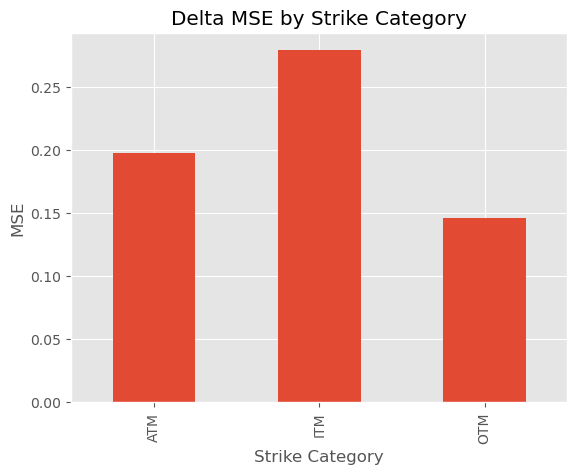

In [108]:
grouped = final_results.groupby('Strike_Category')['Delta_MSE'].mean()
print(grouped)
grouped.plot(kind='bar', title='Delta MSE by Strike Category', ylabel='MSE', xlabel='Strike Category')
plt.show()


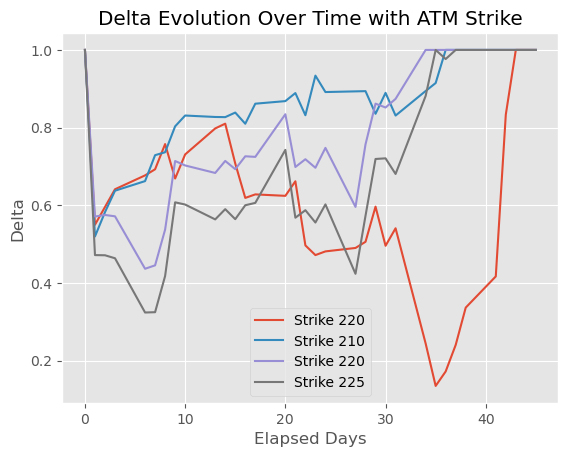

In [109]:
strike_to_plot = final_results[final_results['Strike_Category'] == 'ATM']

for idx, row in strike_to_plot.iterrows():
    option_period = eval(row['Option_Period']) if isinstance(row['Option_Period'], str) else row['Option_Period']
    deltas = eval(row['Deltas']) if isinstance(row['Deltas'], str) else row['Deltas']
    
    plt.plot(option_period, deltas, label=f"Strike {row['Strike']}")

plt.title('Delta Evolution Over Time with ATM Strike')
plt.xlabel('Elapsed Days')
plt.ylabel('Delta')
plt.legend()
plt.show()


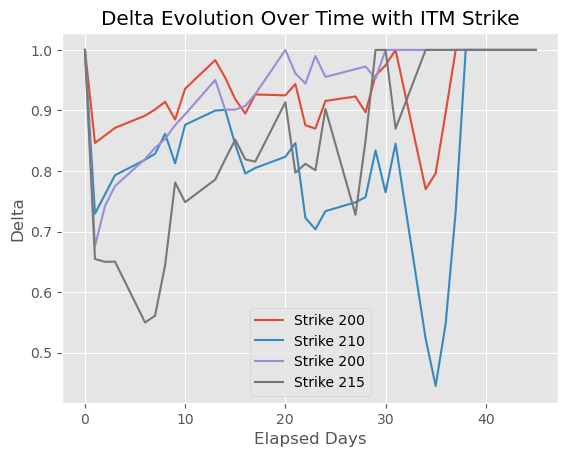

In [110]:
strike_to_plot = final_results[final_results['Strike_Category'] == 'ITM']

for idx, row in strike_to_plot.iterrows():

    option_period = eval(row['Option_Period']) if isinstance(row['Option_Period'], str) else row['Option_Period']
    deltas = eval(row['Deltas']) if isinstance(row['Deltas'], str) else row['Deltas']
    
    plt.plot(option_period, deltas, label=f"Strike {row['Strike']}")

plt.title('Delta Evolution Over Time with ITM Strike')
plt.xlabel('Elapsed Days')
plt.ylabel('Delta')
plt.legend()
plt.show()

C:\Users\Teemu\AppData\Local\Temp\ipykernel_4492\2151181440.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strike_to_plot['Deltas'] = strike_to_plot['Deltas'].apply(lambda x: eval(x) if isinstance(x, str) else x)
C:\Users\Teemu\AppData\Local\Temp\ipykernel_4492\2151181440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strike_to_plot['Option_Period'] = strike_to_plot['Option_Period'].apply(lambda x: eval(x) if isinstance(x, str) else x)


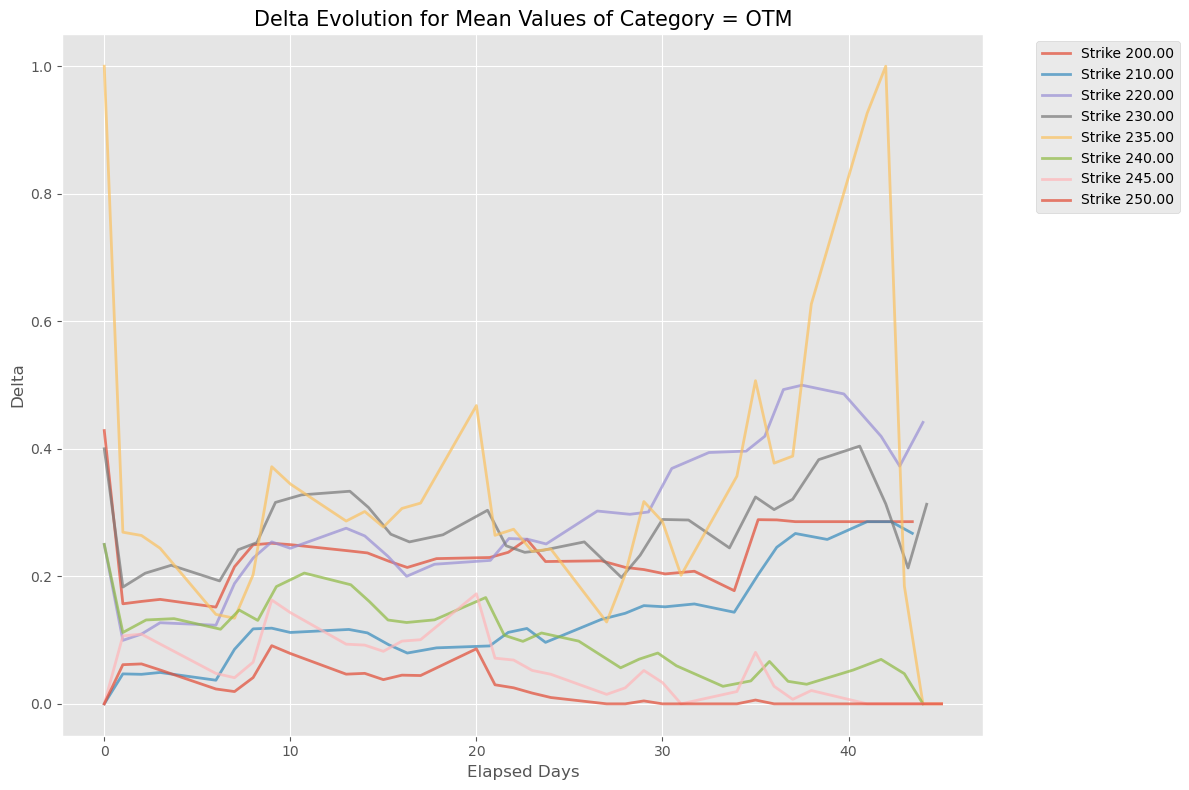

In [84]:
def plot_mean_deltas(final_results, strike_category="OTM"):
    strike_to_plot = final_results[final_results['Strike_Category'] == strike_category]

    strike_to_plot['Deltas'] = strike_to_plot['Deltas'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    strike_to_plot['Option_Period'] = strike_to_plot['Option_Period'].apply(lambda x: eval(x) if isinstance(x, str) else x)

    def align_sequences(sequences):
        min_length = min(len(seq) for seq in sequences)
        return [seq[:min_length] for seq in sequences]

    grouped = (
        strike_to_plot.groupby('Strike')
        .apply(lambda x: pd.Series({
            "Option_Period": np.mean(align_sequences(x['Option_Period'].tolist()), axis=0),
            "Deltas": np.mean(align_sequences(x['Deltas'].tolist()), axis=0),
        }))
        .reset_index()
    )

    plt.figure(figsize=(12, 8))
    plt.style.use('ggplot')

    for _, row in grouped.iterrows():
        plt.plot(
            row['Option_Period'],
            row['Deltas'],
            label=f"Strike {row['Strike']:.2f}",
            linewidth=2,
            alpha=0.7,
        )

    plt.title(f"Delta Evolution for Mean Values of Category = {strike_category}", fontsize=15)
    plt.xlabel("Elapsed Days", fontsize=12)
    plt.ylabel("Delta", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()



plot_mean_deltas(final_results, strike_category="OTM")



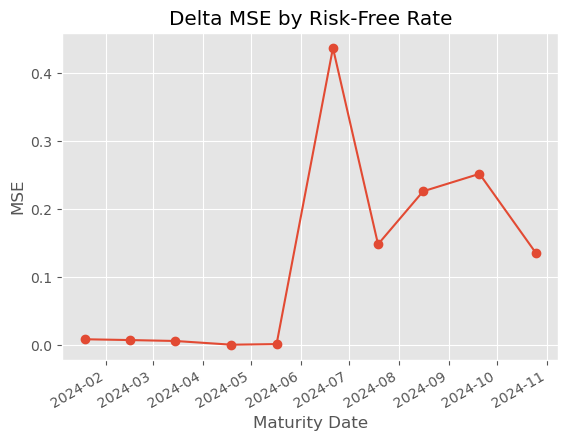

In [55]:
final_results['Maturity'] = pd.to_datetime(final_results['Maturity'], format='%d%m%Y')
grouped_rf = final_results.groupby('Maturity')['Delta_MSE'].mean()

grouped_rf.plot(kind='line', marker='o', title='Delta MSE by Risk-Free Rate', ylabel='MSE', xlabel='Maturity Date')
plt.show()


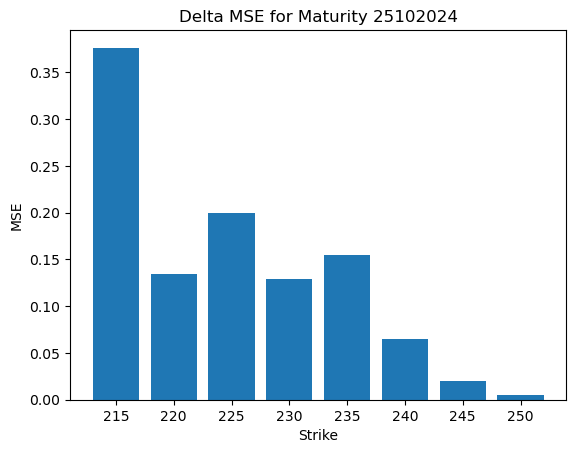

In [27]:
maturity_date = '25102024'
maturity_data = final_results[final_results['Maturity'] == maturity_date]

plt.bar(maturity_data['Strike'], maturity_data['Delta_MSE'])
plt.title(f'Delta MSE for Maturity {maturity_date}')
plt.xlabel('Strike')
plt.ylabel('MSE')
plt.show()


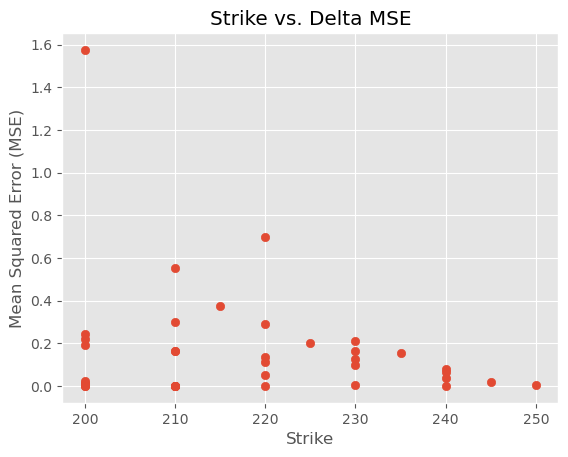

In [101]:
plt.scatter(final_results['Strike'], final_results['Delta_MSE'])
plt.title('Strike vs. Delta MSE')
plt.xlabel('Strike')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()


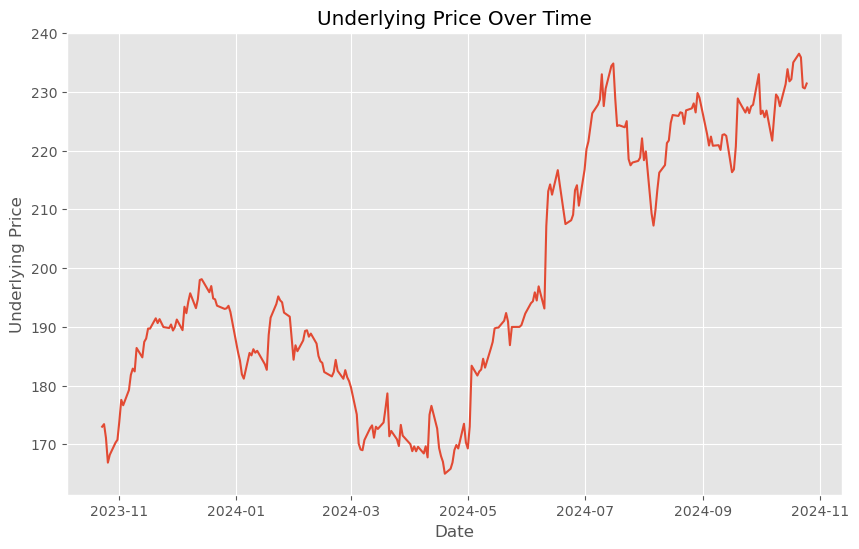

In [1]:
import pandas as pd
import glob

dates = ['19012024', '16022024', '15032024', '19042024','17052024','21062024','19072024','16082024','20092024','25102024']
filenames = [f'data/apple{date}.feather' for date in dates]

dfs = []
for file in filenames:
    try:
        df = pd.read_feather(file)
        columns_to_drop = [col for col in df.columns if col.startswith("C") or col.startswith("P")]
        df = df.drop(columns=columns_to_drop, errors='ignore')
        dfs.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

combined_df = pd.concat(dfs, ignore_index=True)

combined_df = combined_df.drop_duplicates(subset=["Date", "Underlying"])

combined_df["Date"] = pd.to_datetime(combined_df["Date"], format="%d%m%Y")

combined_df = combined_df.sort_values(by="Date")
combined_df.to_feather("data/combined_data.feather")

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(combined_df["Date"], combined_df["Underlying"], linestyle='-')
plt.xlabel("Date")
plt.ylabel("Underlying Price")
plt.title("Underlying Price Over Time")
plt.grid(True)
plt.show()
